In [ ]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d splcher/animefacedataset

 94% 372M/395M [00:01<00:00, 239MB/s]
100% 395M/395M [00:01<00:00, 246MB/s]


In [ ]:
!unzip '/root/animefacedataset.zip' -d '/content/'

In [14]:
DATA_DIR='/content/animefacedataset/'

In [15]:
import os
print(os.listdir(DATA_DIR+'/images')[:10])

['2838_2002.jpg', '8670_2004.jpg', '24783_2009.jpg', '3623_2002.jpg', '19299_2007.jpg', '51056_2015.jpg', '24236_2008.jpg', '28073_2009.jpg', '34157_2011.jpg', '62148_2019.jpg']


In [16]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [22]:
image_size=64
batch_size=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [23]:
train_ds=ImageFolder(DATA_DIR,transform=T.Compose([
                                                    T.Resize(image_size),
                                                    T.CenterCrop(image_size),
                                                    T.ToTensor(),
                                                    T.Normalize(*stats)
]))

train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=3,pin_memory=True)

In [24]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
def denorm(img_tensor):
  return img_tensor*stats[1][0] + stats[0][0]

In [43]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

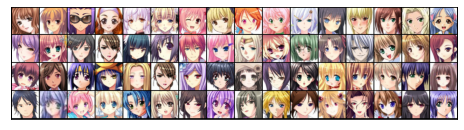

In [31]:
show_batch(train_dl)

In [33]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if(isinstance(data,(list,tuple))):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device 

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)   

In [34]:
device=get_default_device()
device

device(type='cuda')

In [35]:
train_dl=DeviceDataLoader(train_dl,device)

In [37]:
import torch.nn as nn

#Discriminator network

In [38]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [39]:
discriminator=to_device(discriminator,device)

#Generator Network

In [40]:
latent_size=128

In [41]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


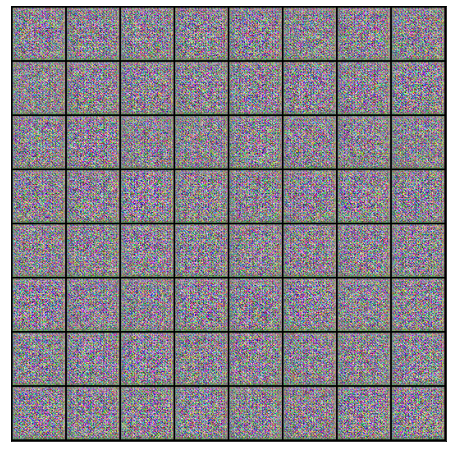

In [44]:
xb=torch.randn(batch_size,latent_size,1,1)
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [45]:
generator=to_device(generator,device)

#Training Discriminator

In [46]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

#Training Generator

In [47]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [48]:
from torchvision.utils import save_image

In [54]:
sample_dir='generated'
os.makedirs(sample_dir,exist_ok=True)

In [55]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [56]:
fixed_latent=torch.randn(64,latent_size,1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


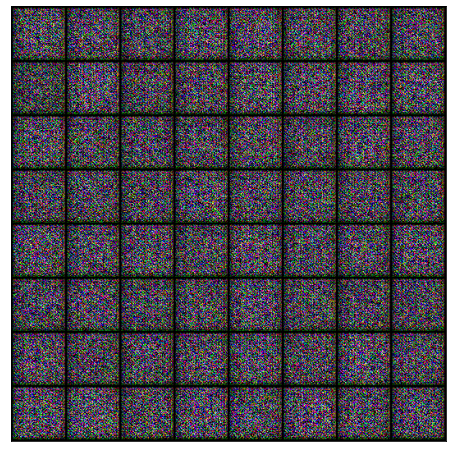

In [57]:
save_samples(0,fixed_latent)

In [58]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [60]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [61]:
lr=0.002
epochs=5

In [62]:
history=fit(epochs,lr)


Epoch [1/5], loss_g: 5.9094, loss_d: 2.9360, real_score: 0.9968, fake_score: 0.8576
Saving generated-images-0001.png



Epoch [2/5], loss_g: 7.1615, loss_d: 0.4851, real_score: 0.8726, fake_score: 0.2503
Saving generated-images-0002.png



Epoch [3/5], loss_g: 7.4959, loss_d: 0.4034, real_score: 0.9180, fake_score: 0.2266
Saving generated-images-0003.png



Epoch [4/5], loss_g: 5.0993, loss_d: 0.6549, real_score: 0.6471, fake_score: 0.0085
Saving generated-images-0004.png



Epoch [5/5], loss_g: 3.2619, loss_d: 1.2167, real_score: 0.4810, fake_score: 0.0264
Saving generated-images-0005.png


In [63]:
torch.save(generator.state_dict(),'G.ckpt')
torch.save(discriminator.state_dict(),'D.ckpt')

In [65]:
from IPython.display import Image

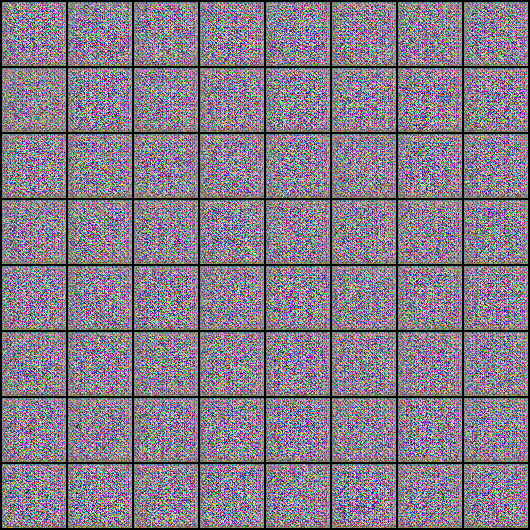

In [71]:
Image('/content/generated/generated-images-0000.png')

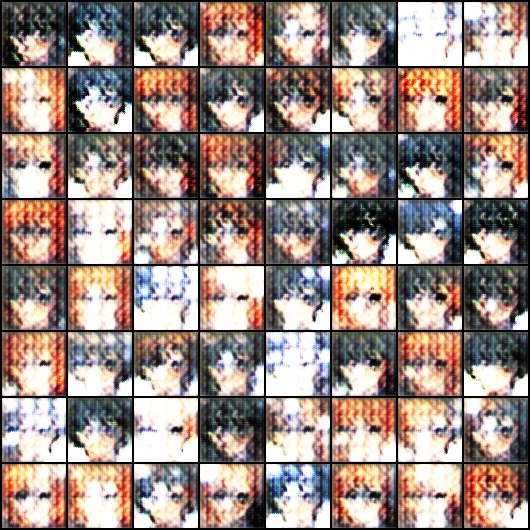

In [67]:
Image('/content/generated/generated-images-0001.png')

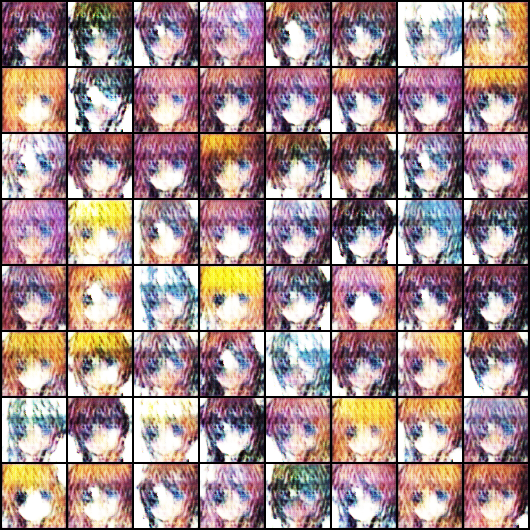

In [68]:
Image('/content/generated/generated-images-0002.png')

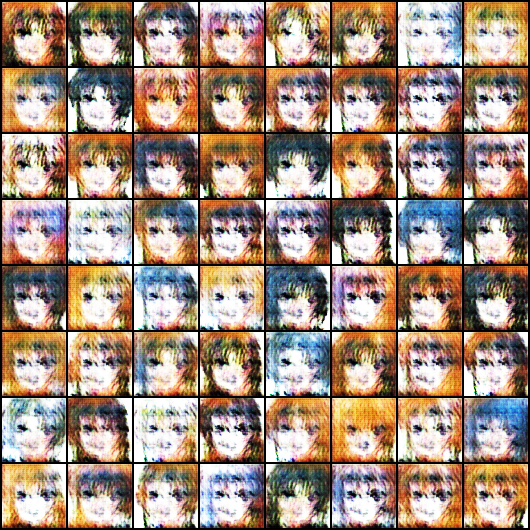

In [69]:
Image('/content/generated/generated-images-0003.png')

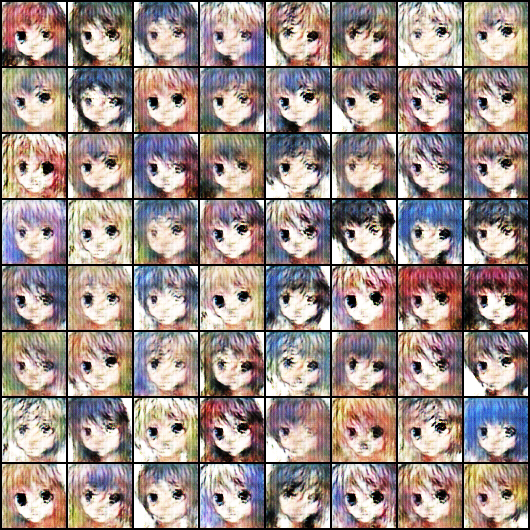

In [70]:
Image('/content/generated/generated-images-0004.png')

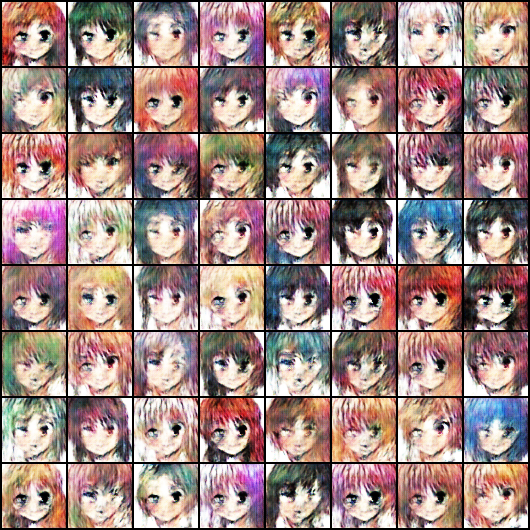

In [66]:
Image('/content/generated/generated-images-0005.png')